In [1]:
using CSV
using DataFramesMeta
using DataFrames
using CategoricalArrays
using Gadfly
using Statistics
using StatsBase
using Distributions
using StatsFuns
using SpecialFunctions
using StatsFuns
using Optim
using ForwardDiff
using Cairo
using Fontconfig
using Distributed
using Loess
using GLM
using Interpolations
using JLD
cd("/Users/evanrussek/foraging/")

In [2]:
data = CSV.read("/Users/evanrussek/forage_jsp/analysis/data/run6_data.csv");


In [3]:
harvest_keys = unique(data.harvest_key)
harvest_key_easy = harvest_keys[1]
harvest_key_hard = harvest_keys[2]
harvest_keys_he = [harvest_key_hard harvest_key_easy];

In [4]:
function clean_subj_data(s_data, harvest_keys_he)
    # clean the a subjects data,
    # takes in raw data (DataFrame) for a single subject 
    # returns a cleaned dataframe... should work on both datasets...
    
    harvest_key_hard = harvest_keys_he[1];
    harvest_key_easy = harvest_keys_he[2];
    
    s_data = @select(s_data,:round, :phase, :reward_obs,
                                :reward_true, :lag, :exit, :start_reward, :n_travel_steps,
                                :harvest_key, :subjectID, :trial_num, :s_num, :correct_key, :time_elapsed)

    trial_press_num_df = by(s_data,:trial_num, df -> DataFrame(press_num = 1:nrow(df)))
    s_data.press_num = trial_press_num_df.press_num

    # change phase name, travel_key
    s_data = @byrow! s_data begin
                if :phase == "Harvest"
                :phase = "HARVEST"
                end
                @newcol harvest_key_cond::Array{String,1}
                if :harvest_key == harvest_key_hard
                        :harvest_key_cond = "HARD"
                else
                        :harvest_key_cond = "EASY"
                end
        end

        return s_data
end
function clean_group_data(data, harvest_keys_he)
    # clean data for the whole group -- returns cdata
    
    data.s_num = groupindices(groupby(data,:subjectID))
    data.subj = CategoricalArray(data.s_num)
    n_subj = length(unique(data.subj))
    
    # aggregate all clean data...
    cdata = DataFrame();
    for s = 1:n_subj
            #global cdata
            s_data = @where(data,:subj .== s)
            cdata = vcat(cdata,clean_subj_data(s_data,harvest_keys_he))
    end
    
    # just adjust the rewards from the second run...
    cdata.start_reward[cdata.start_reward .== 105] .= 100;
    cdata.start_reward[cdata.start_reward .== 53] .= 50;
    return (cdata, n_subj)
end


clean_group_data (generic function with 1 method)

In [5]:
cdata, n_subj = clean_group_data(data,harvest_keys_he);
n_subj

50

In [6]:
function prep_subj_data(data_in)

    #s_data = DataFrame();

    s_data = DataFrame(data_in);#copy(data_in);
    s_data[!,:lag_scale] = copy(s_data[!,:lag]); # is this wrong?
    s_data[!,:lag] = s_data[!,:lag_scale] ./ 100;

    # add trial time elapsed...
    s_data[!,:trial_time_elapsed] = zeros(length(s_data[!,:time_elapsed]));
    for t_idx in unique(s_data.trial_num)
        tdat = s_data[s_data[!,:trial_num].==t_idx,:];
        s_data[s_data[!,:trial_num].==t_idx, :trial_time_elapsed] = tdat.time_elapsed .- tdat.time_elapsed[1];
    end

    s_data[ismissing.(s_data[!,:reward_obs]),:reward_obs] .= 0;
    s_data[ismissing.(s_data[!,:exit]),:exit] .= 1;
    s_data[!,:choice] = s_data[!,:exit] .+ 1;
    s_data[!,:choice] = convert(Array{Int,1}, s_data[!,:choice]);

    # make a column that splits by press type
    s_data[!,:button] .= string();
    s_data[s_data[!,:phase] .== "TRAVEL", :button] .= "TRAVEL";
    s_data[(s_data[!,:phase] .== "HARVEST") .& (s_data[!,:harvest_key_cond] .== "HARD"), :button] .= "HARVEST_HARD";
    s_data[(s_data[!,:phase] .== "HARVEST") .& (s_data[!,:harvest_key_cond] .== "EASY"), :button] .= "HARVEST_EASY";
    # this uses a split of 3, but changes by button press type...
    button_lag_thresh_df = by(s_data, :button, df -> DataFrame(upper_lag_thresh2 = median(df.lag) + 2*mad(df.lag),
            lower_lag_thresh2 = median(df.lag) - 2*mad(df.lag)))
    s_data = join(s_data, button_lag_thresh_df, on = :button, kind = :left);
    s_data.trial_time_sec = s_data.trial_time_elapsed./1000;
    s_data.upper_lag_thresh = median(s_data.lag) + 4*mad(s_data.lag);
    s_data.lower_lag_thresh = median(s_data.lag) - 4*mad(s_data.lag); # 4 sds...

    sub_df = s_data[!, [:round, :trial_num, :lag, :lag_scale, :choice, :phase, :start_reward,
            :reward_obs, :harvest_key_cond, :subjectID, :reward_true, :trial_time_elapsed, :button,
            :upper_lag_thresh, :lower_lag_thresh, :trial_time_sec, :upper_lag_thresh2, :lower_lag_thresh2]];

    return sub_df
end


prep_subj_data (generic function with 1 method)

In [7]:
# now want to do prep subj data...
cdata[!,:sub] = cdata[!,:s_num];
pdata = by(cdata, :sub, df -> prep_subj_data(df));
pdata[!,:remove] .= false;

┌ Warning: the `normalize` keyword argument will be false by default in future releases: set it explicitly to silence this deprecation
│   caller = (::var"#12#13")(::SubDataFrame{DataFrame,DataFrames.Index,Array{Int64,1}}) at In[6]:27
└ @ Main ./In[6]:27
┌ Warning: the `normalize` keyword argument will be false by default in future releases: set it explicitly to silence this deprecation
│   caller = (::var"#12#13")(::SubDataFrame{DataFrame,DataFrames.Index,Array{Int64,1}}) at In[6]:27
└ @ Main ./In[6]:27
┌ Warning: the `normalize` keyword argument will be false by default in future releases: set it explicitly to silence this deprecation
│   caller = prep_subj_data(::SubDataFrame{DataFrame,DataFrames.Index,Array{Int64,1}}) at In[6]:31
└ @ Main ./In[6]:31
┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = prep_subj_data(::SubDataFrame{DataFrame,DataFrames.Index,Array{Int64,1}}) at In[6]:31
└ @ Main ./In[6]:31
┌ Warn

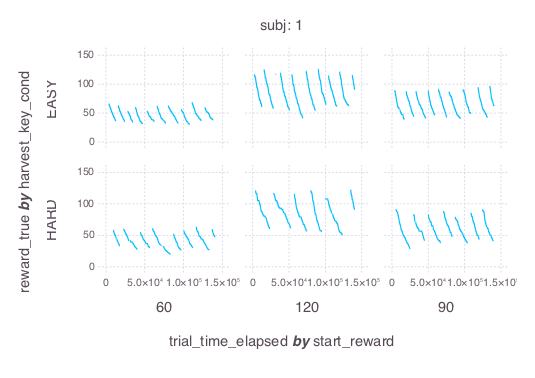

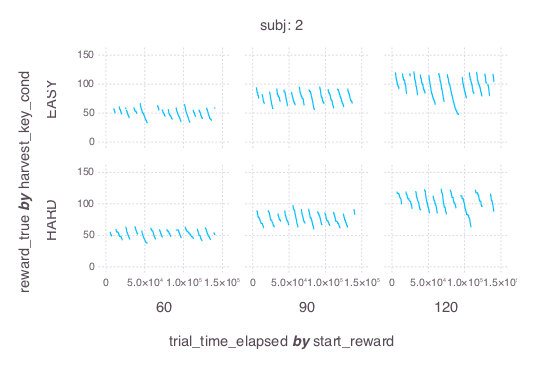

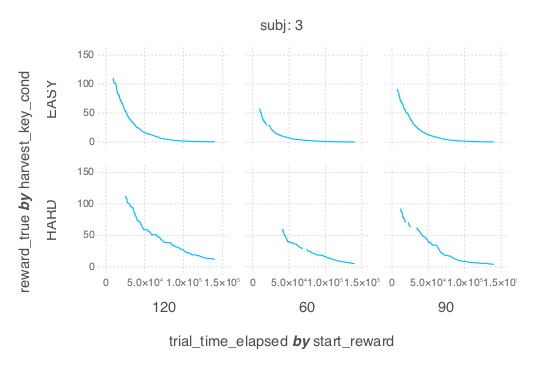

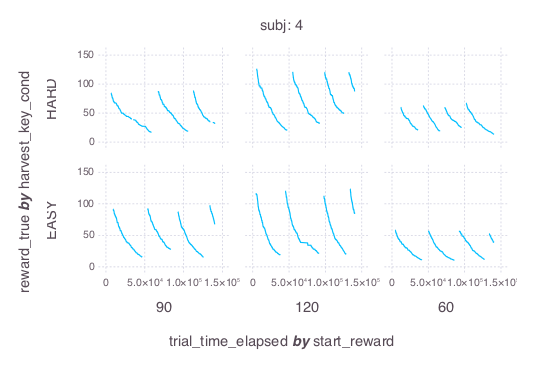

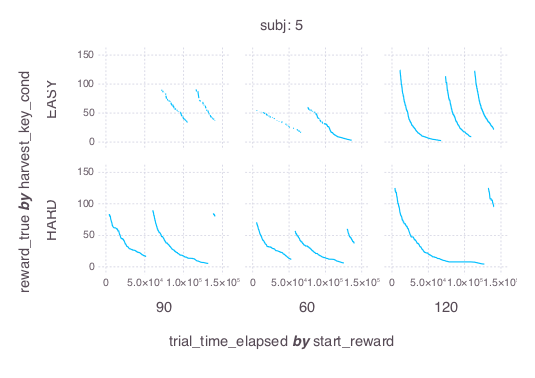

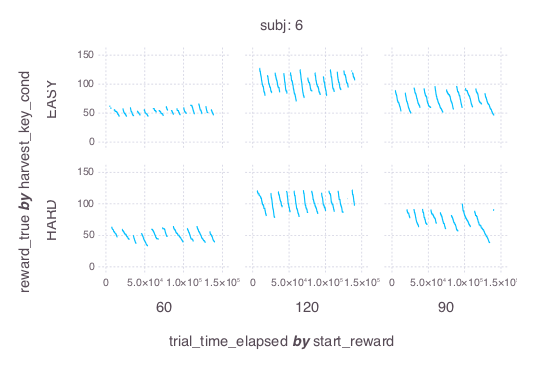

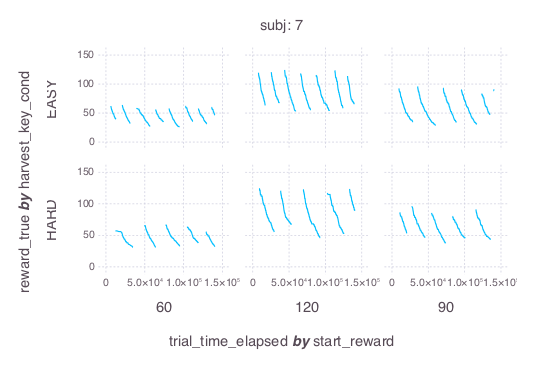

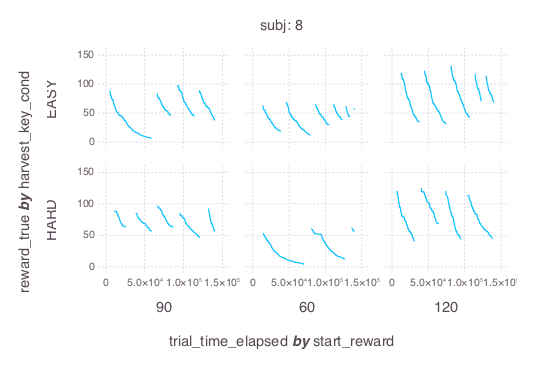

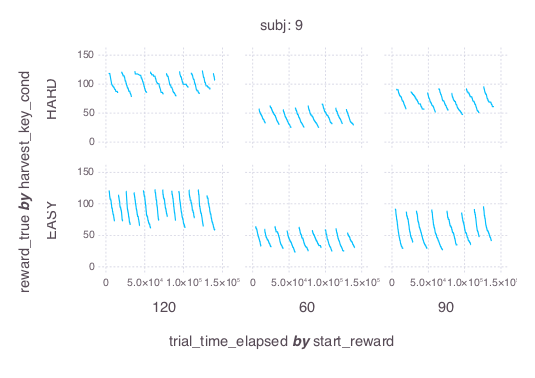

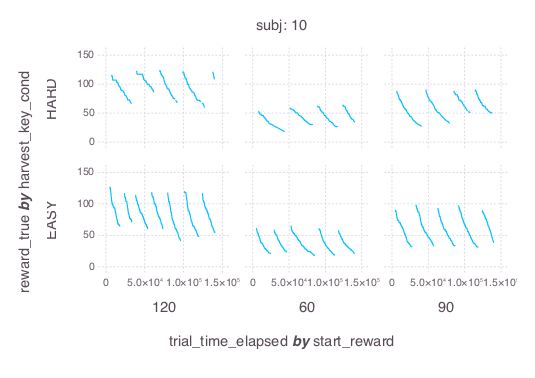

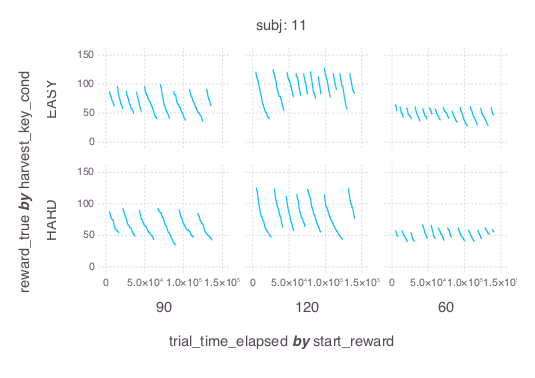

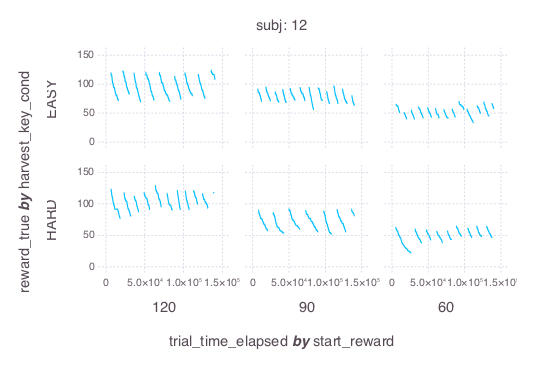

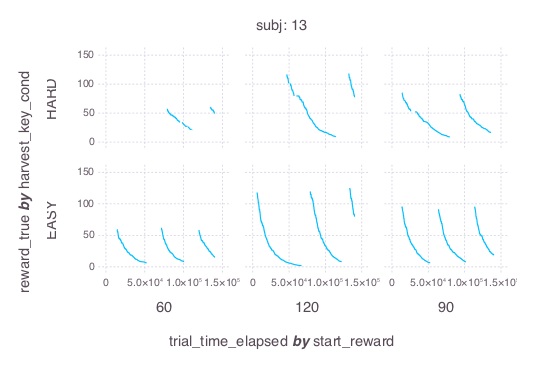

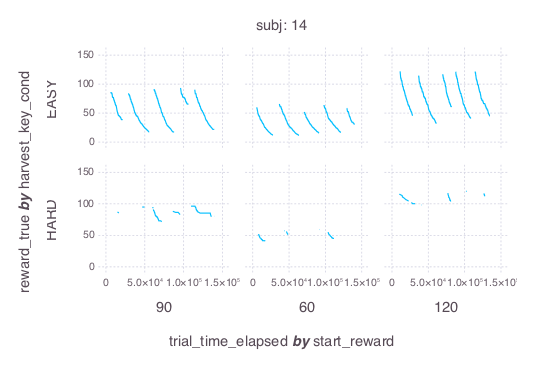

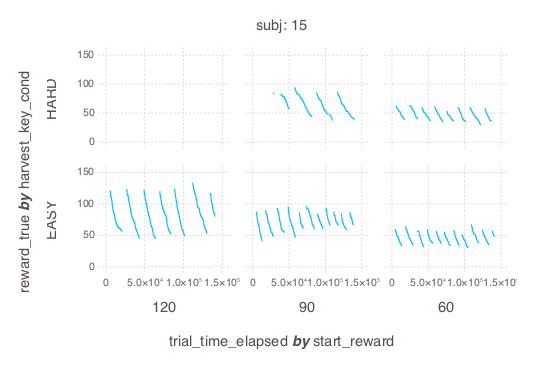

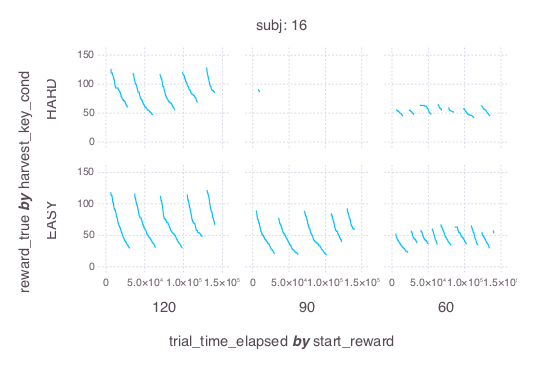

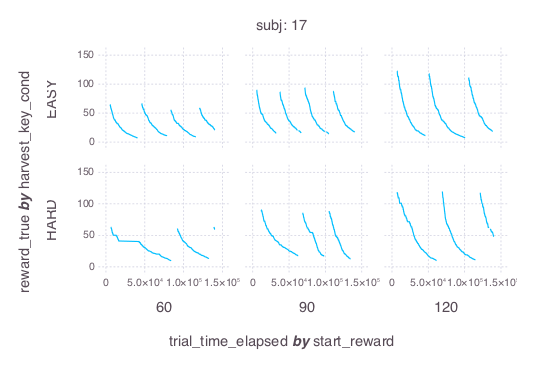

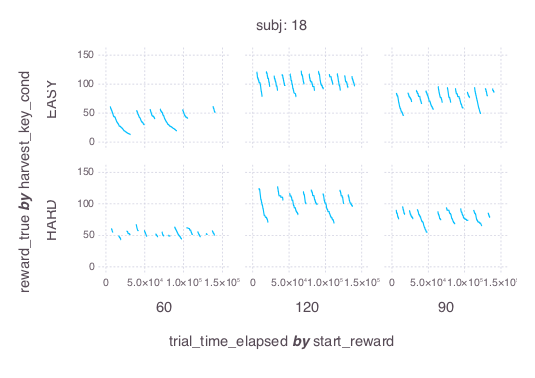

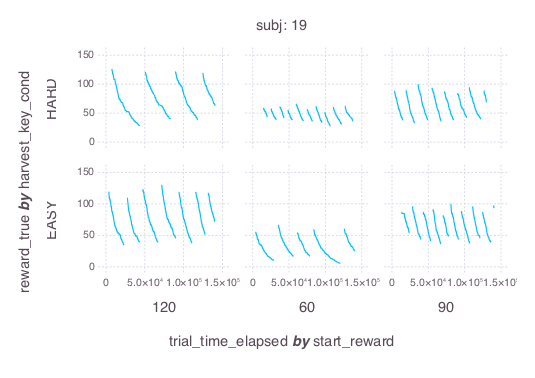

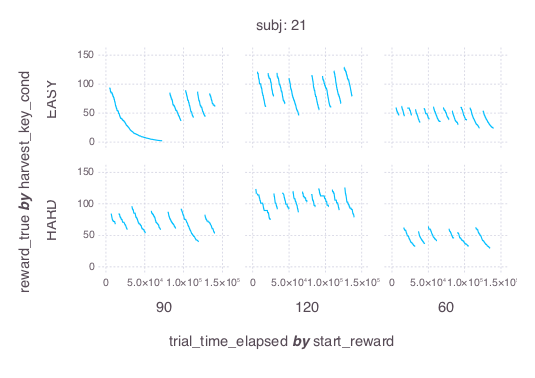

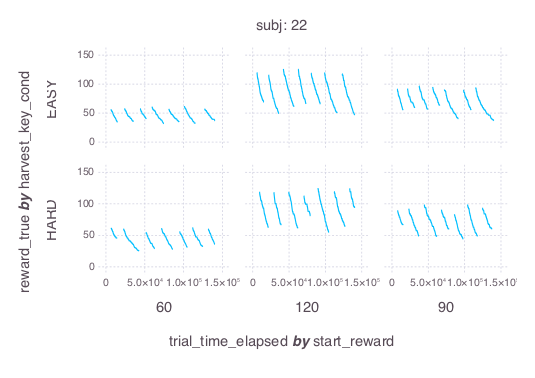

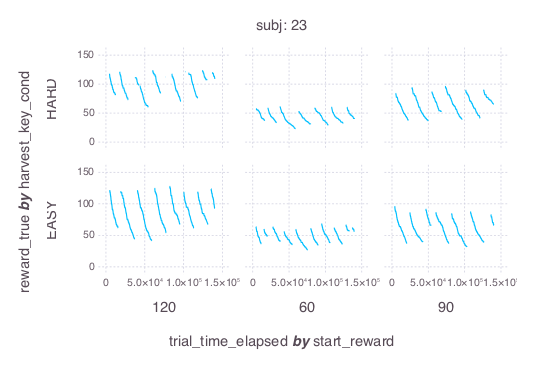

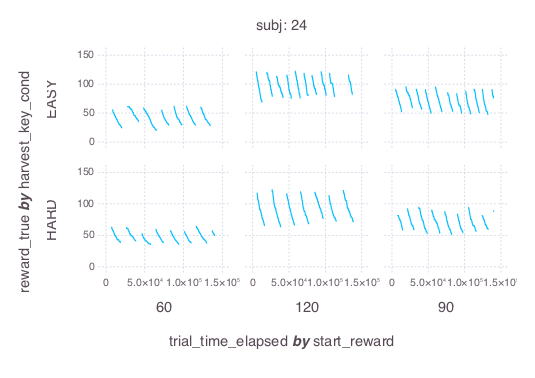

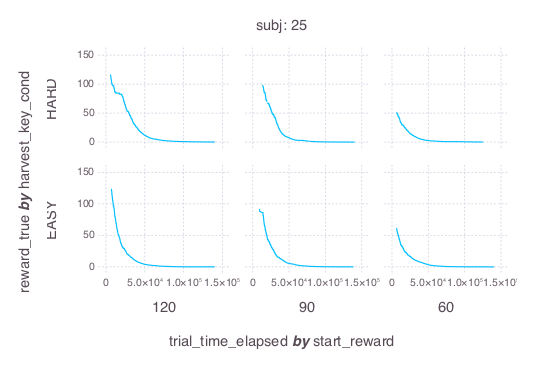

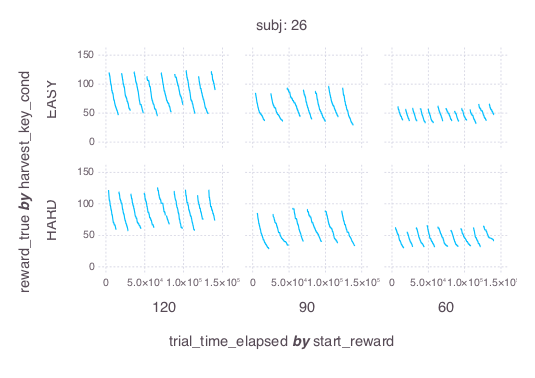

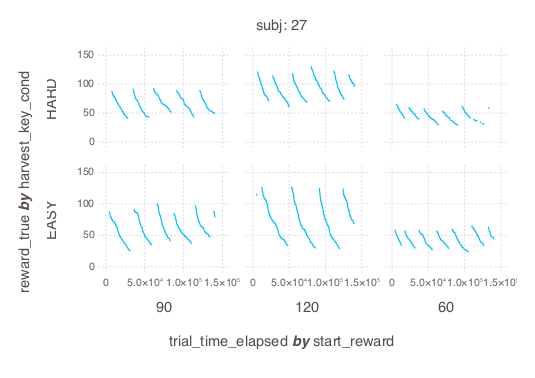

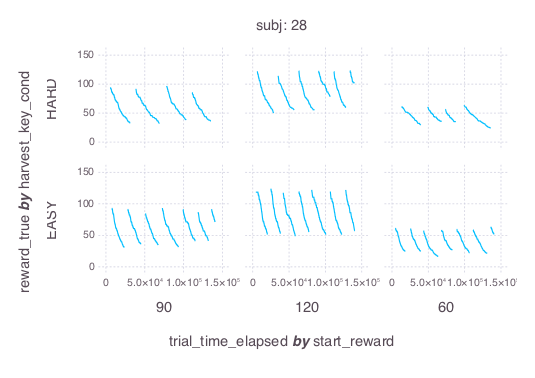

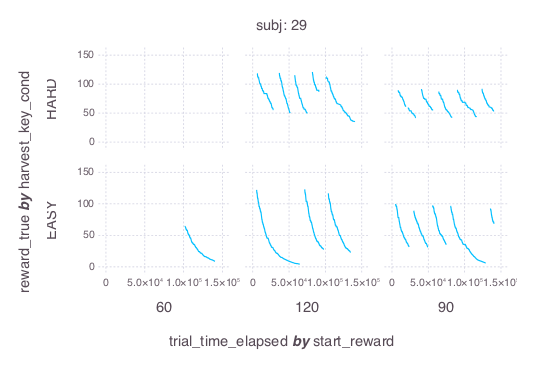

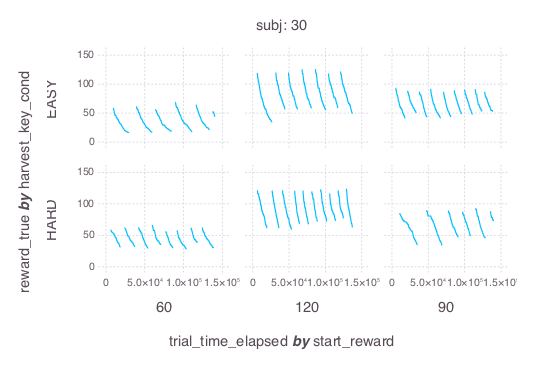

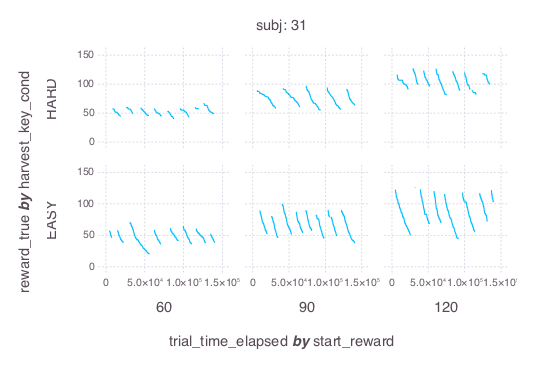

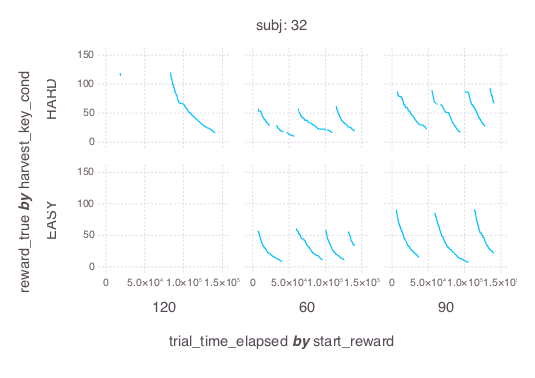

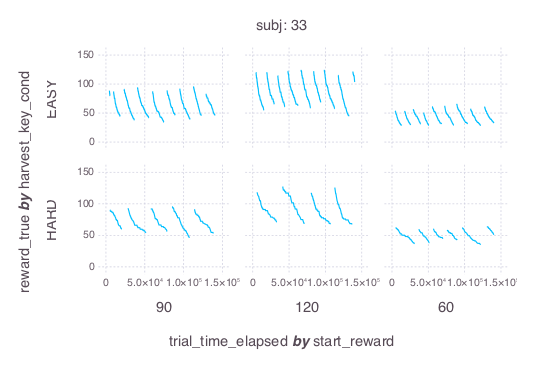

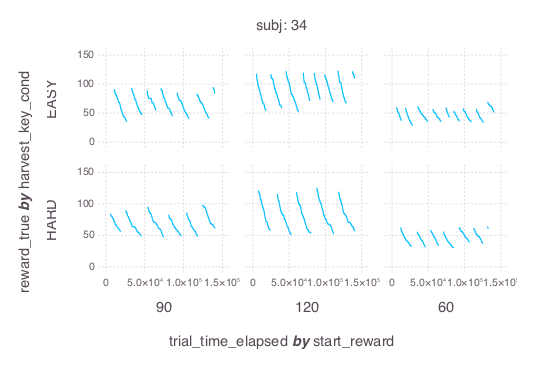

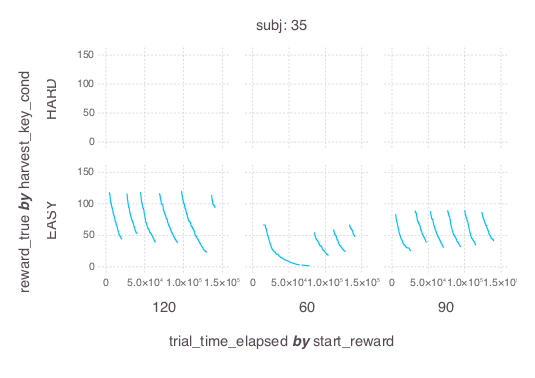

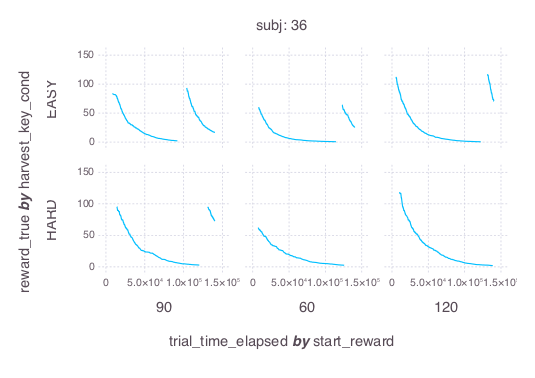

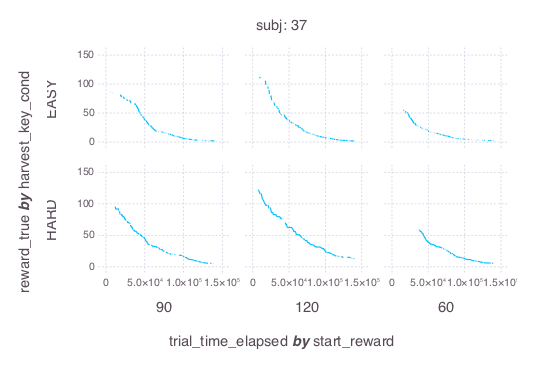

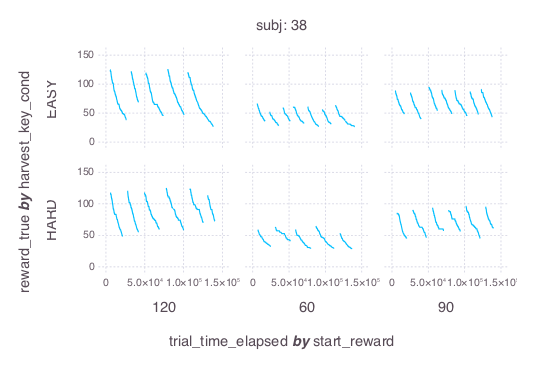

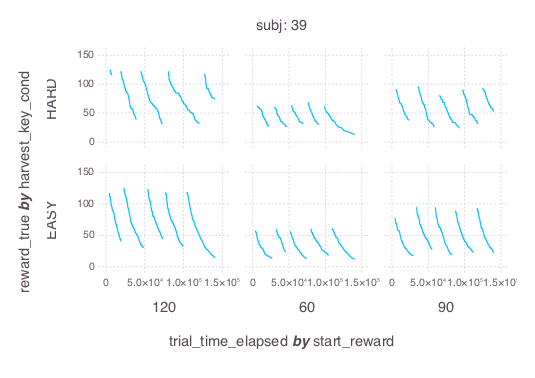

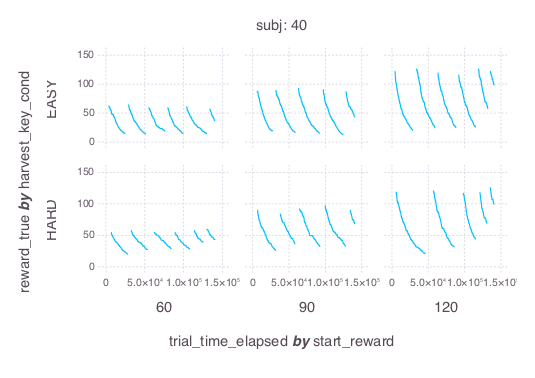

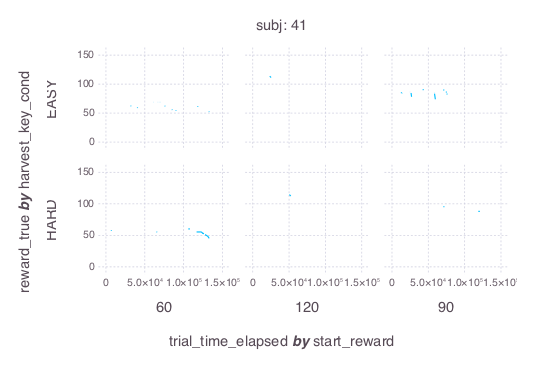

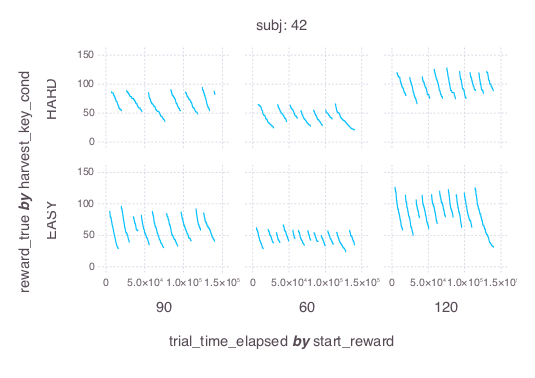

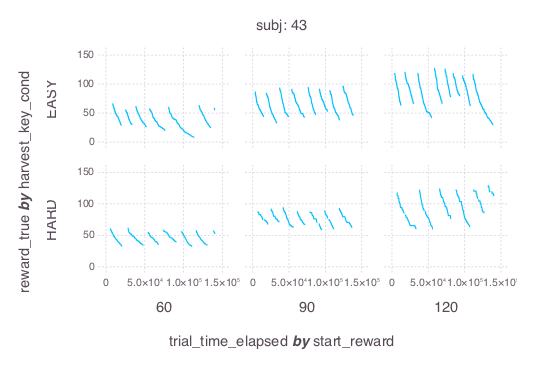

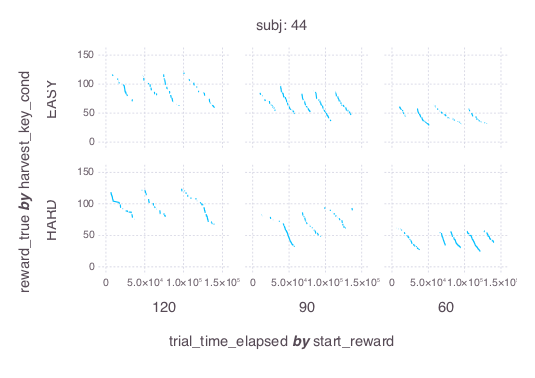

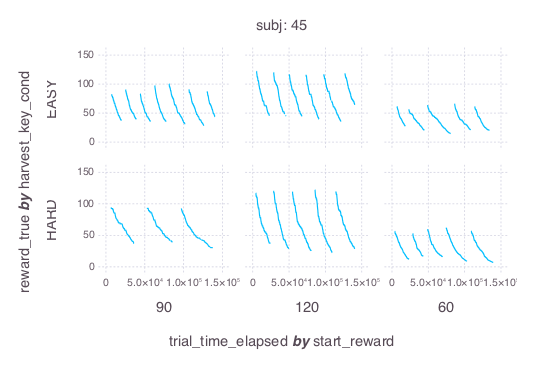

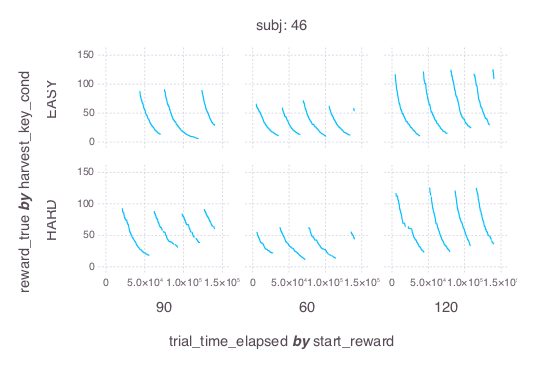

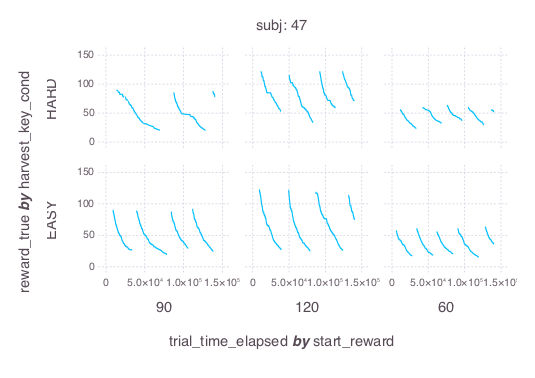

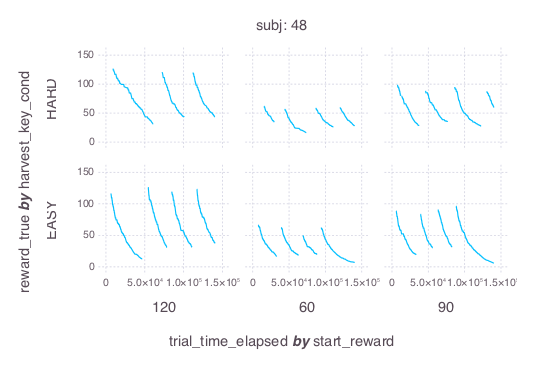

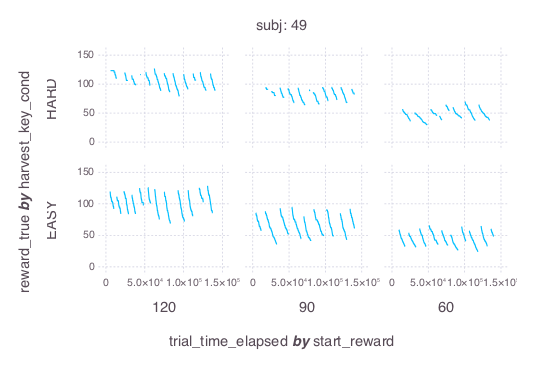

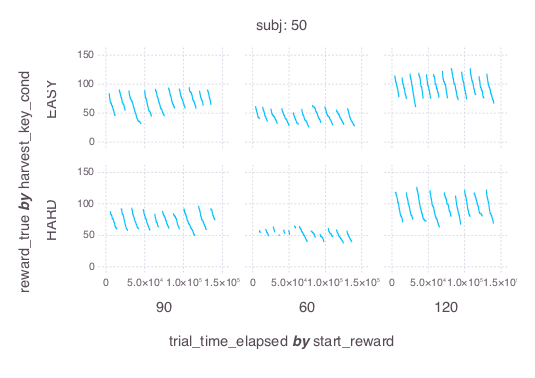

┌ Warning: implicit broadcasting in setindex! is deprecated; use `df[row_inds, col_ind] .= Ref(v)` broadcasting assignment to change the column in place
│   caller = top-level scope at In[8]:16
└ @ Core ./In[8]:16


BoundsError: BoundsError: attempt to access 11-element Array{Int64,1} at index [15]

In [8]:
# get subjects to remove...
for i in 1:n_subj
    try
        s_data = @where(pdata, :sub .== i)
        #s_data.start_reward_cat = CategoricalArray(s_data.start_reward)
        p = plot(s_data, x = :trial_time_elapsed, y = :reward_true, 
            xgroup = :start_reward, ygroup = :harvest_key_cond,
            Geom.subplot_grid(Geom.line), Guide.title(string("subj: ", i)));
        draw(PNG(),p)
    catch
    end
end

bad_subj = [3, 15, 16,  20, 25, 29, 32, 35, 36, 37, 41] #  10 subjects...
for i in bad_subj
    pdata[pdata[!,:sub] .== bad_subj[i] ,:remove] = true
end
    

In [9]:
# make group lag plot...
function make_group_lag_df(pdata)
    new_pdata = copy(pdata);
    new_pdata = by(new_pdata, [:sub, :trial_num, :round, :phase]) do df
            if (size(df,1) > 10)
                these_idx = 2:size(df,1)
            else
                these_idx = 2:size(df,1)
            end
             df[these_idx, [:lag, :lag_scale, :choice, :start_reward, :reward_obs,
                        :harvest_key_cond, :subjectID, :reward_true, :upper_lag_thresh, :lower_lag_thresh, :upper_lag_thresh2, :lower_lag_thresh2,
                        :remove]];
            end
    
    new_pdata = @where(new_pdata, :lag .> :lower_lag_thresh,  :lag .< :upper_lag_thresh);
    trial_lag_df = by(new_pdata, [:sub,:trial_num, :phase],
        df -> DataFrame(start_reward = first(df.start_reward),
                harvest_key_cond = first(df.harvest_key_cond), lag = median(df.lag_scale),
                log_lag = mean(log.(df.lag_scale)),subjectID = df.subjectID[1]
            )
        )
    group_lag_df = by(trial_lag_df, [:start_reward, :harvest_key_cond, :phase],
                        :log_lag => mean,
                        :log_lag => std)
    group_lag_df[!,:upper] = group_lag_df[!,:log_lag_mean] + group_lag_df[!,:log_lag_std] ./ sqrt(n_subj);
    group_lag_df[!,:lower] = group_lag_df[!,:log_lag_mean] - group_lag_df[!,:log_lag_std] ./ sqrt(n_subj);
    group_lag_df[!,:start_reward_cat] = CategoricalArray(group_lag_df[!,:start_reward]);
    return group_lag_df
end


make_group_lag_df (generic function with 1 method)

In [10]:
function make_group_lag_plot(pdata; title = "", side = "left")
    group_lag_df = make_group_lag_df(pdata);

    if side == "right"
        plot(group_lag_df, x = :start_reward_cat, y = :log_lag_mean, color = :harvest_key_cond,
            ymax = :upper, ymin = :lower, xgroup = :phase,
            Geom.subplot_grid(Geom.line(), Geom.point(), Geom.errorbar()),
            Scale.x_discrete(levels = sort(unique(group_lag_df[!,:start_reward_cat]))),
            Scale.color_discrete(levels = ["HARD", "EASY"]),
            Guide.ylabel("Log Lag"),
            Guide.xlabel("Tree First Reward by Part", orientation = :horizontal),
            Guide.title(title),
            Theme(key_position = :none))
    else
        return plot(group_lag_df, x = :start_reward_cat, y = :log_lag_mean, color = :harvest_key_cond,
            ymax = :upper, ymin = :lower, xgroup = :phase,
            Geom.subplot_grid(Geom.line(), Geom.point(), Geom.errorbar()),
            Scale.x_discrete(levels = sort(unique(group_lag_df[!,:start_reward_cat]))),
            Scale.color_discrete(levels = ["HARD", "EASY"]),
            Guide.ylabel("Log Lag"),
            Guide.xlabel("Tree First Reward by Part", orientation = :horizontal),
            Guide.colorkey(title = "Harvest Key"),
            Guide.title(title))

    end

end

make_group_lag_plot (generic function with 1 method)

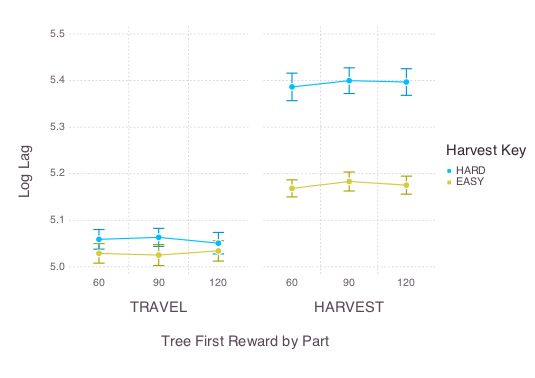

false

In [13]:
lag_plot = make_group_lag_plot(pdata)
draw(PNG(), lag_plot)

In [19]:
function get_trial_exit_threshs(trial_data)

    if size(trial_data,1) > 1
        exit_tbl = by(trial_data, :round) do df
            non_missing_harvest = @where(df, .&(:phase .== "HARVEST", :reward_obs .> 0));
            if size(non_missing_harvest,1) > 0
                last_reward = non_missing_harvest.reward_true[end];
                last_reward_time = non_missing_harvest.trial_time_elapsed[end];
                df.reward_obs[ismissing.(df.reward_obs)] .= 0;

                this_df = DataFrame(
                    subjectID = df.subjectID[1],
                    last_reward = last_reward,
                    start_reward = df.start_reward[1],
                    last_reward_time = last_reward_time,
                    harvest_key_cond = df.harvest_key_cond[1],
                    );
            else
                this_df = DataFrame(
                    subjectID = [],
                    last_reward = [],
                    last_reward_time = [],
                    start_reward = [],
                    harvest_key_cond = []);
            end

            return this_df
        end # this ends the do
    else
        exit_tbl = DataFrame(
        subjectID = [],
        last_reward = [],
        round = [],
        start_reward = [],
        harvest_key_cond = []);
    end
    return exit_tbl
end

## plot the exit threshold?
function make_group_trial_exit(pdata)
    round_exit_data = by(pdata, [:sub, :trial_num], df -> get_trial_exit_threshs(df));

    trial_exit_data = by(round_exit_data, [:sub, :trial_num],
                start_reward = :start_reward => first,
                harvest_key_cond = :harvest_key_cond => first,
                exit_thresh = :last_reward  => mean
        );

    group_trial_exit = by(trial_exit_data, [:start_reward, :harvest_key_cond],
        exit_thresh = :exit_thresh => mean,
        exit_sd = :exit_thresh => std)

    group_trial_exit[!,:upper] = group_trial_exit[!,:exit_thresh] + group_trial_exit[!,:exit_sd] ./ sqrt(n_subj);
    group_trial_exit[!,:lower] = group_trial_exit[!,:exit_thresh] - group_trial_exit[!,:exit_sd] ./ sqrt(n_subj);
    group_trial_exit[!,:start_reward_cat] = CategoricalArray(group_trial_exit[!,:start_reward]);
    return group_trial_exit
end

make_group_trial_exit (generic function with 1 method)

In [20]:
function make_group_exit_plot(pdata; title = "", bounds = [0, 100])
    group_trial_exit = make_group_trial_exit(pdata);
    return plot(group_trial_exit, x = :start_reward_cat, y = :exit_thresh, ymin = :lower, ymax = :upper,
        color = :harvest_key_cond, Geom.line(), Geom.point(),
        Geom.errorbar(),
        Scale.x_discrete(levels = sort(unique(group_trial_exit[!,:start_reward_cat]))),
        Scale.color_discrete(levels = ["HARD", "EASY"]),
        Guide.title(title),
        Guide.xlabel("Tree First Reward", orientation = :horizontal),
        Guide.ylabel("Last Reward Before Exit"),
        Guide.colorkey(title = "Harvest Key"),
        Coord.Cartesian(ymin = bounds[1], ymax = bounds[2])
    )
end

make_group_exit_plot (generic function with 1 method)

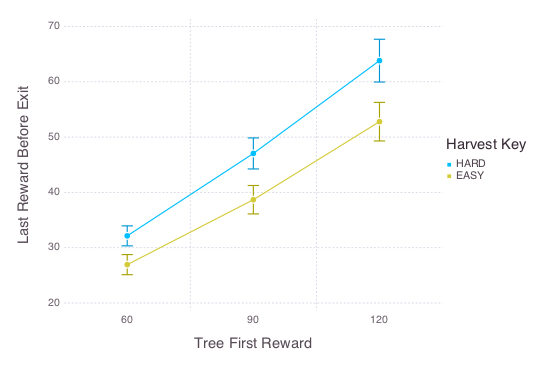

false

In [21]:
# need to plot this in terms of rate...
exit_plot = make_group_exit_plot(pdata; bounds = [20, 70])
draw(PNG(),exit_plot)

In [22]:
### plot exit thresh over time...

### let's make the plots over time...
# make the lag over time and thresh over time plots
function make_smooth_rr_DF(pdata)
    pdata_lt = @where(pdata,:lag .< :upper_lag_thresh, :lag .> :lower_lag_thresh)
    pdata_lt.log_lag = log.(pdata_lt.lag)
    smooth_rr_DF = DataFrame();
    for s_idx in unique(pdata_lt.sub)
        print(s_idx)
        sub_rr_DF = DataFrame();

        s_data = @where(pdata_lt, :sub .== s_idx);
        s_data.lag_z = zscore(s_data.log_lag);
        for t_idx in unique(pdata_lt.trial_num)
            s_trial_harvest_data = @where(s_data, :phase .== "HARVEST", :trial_num .== t_idx);
            harvest_DF= try
                harvest_model = loess(s_trial_harvest_data.trial_time_sec, s_trial_harvest_data.lag_z);
                us_harvest = range(extrema(s_trial_harvest_data.trial_time_sec)...; step = 1)
                vs_harvest = Loess.predict(harvest_model, us_harvest);

                DataFrame(trial_time_sec = us_harvest, lag_smooth = vs_harvest, trial_num = t_idx, sub = s_idx,
                                        start_reward = s_trial_harvest_data[1,:start_reward],
                                        harvest_key_cond = s_trial_harvest_data[1,:harvest_key_cond],phase = "HARVEST");
                catch e
                  bt = backtrace()
                  msg = sprint(showerror, e, bt)
                  #println(msg)
                    DataFrame();
                end

            s_trial_travel_data = @where(s_data, :phase .== "TRAVEL", :trial_num .== t_idx);
            travel_DF = try

                travel_model = loess(s_trial_travel_data.trial_time_sec, s_trial_travel_data.lag_z);
                us_travel = range(extrema(s_trial_travel_data.trial_time_sec)...; step = 1)
                vs_travel = Loess.predict(travel_model, us_travel);
                DataFrame(trial_time_sec = us_travel, lag_smooth = vs_travel, trial_num = t_idx, sub = s_idx,
                                        start_reward = s_trial_travel_data[1,:start_reward],
                                        harvest_key_cond = s_trial_travel_data[1,:harvest_key_cond],phase = "TRAVEL");
            catch
                DataFrame();
            end

            sub_rr_DF = [sub_rr_DF; harvest_DF; travel_DF];
        end # end loop over trials
        #if (any(sub_rr_DF.lag_smooth .> 8) | any(sub_rr_DF.lag_smooth .< -10))
         #   print("small_lag")
        #end
        #print(sub_rr_DF)
        if (length(unique(sub_rr_DF.trial_num)) == length(unique(pdata_lt.trial_num))) & !(any(sub_rr_DF.lag_smooth .> 8) | any(sub_rr_DF.lag_smooth .< -8))
            smooth_rr_DF = [smooth_rr_DF; sub_rr_DF];
        end
    end
    smooth_rr_DF.trial_time_sec = ceil.(smooth_rr_DF.trial_time_sec);
    return smooth_rr_DF
end

function plot_group_rr_over_time(pdata_lt)

    smooth_rr_DF = make_smooth_rr_DF(pdata_lt);

    smooth_rr_means = by(smooth_rr_DF,
        [:trial_time_sec, :start_reward, :harvest_key_cond, :phase],
        :lag_smooth => mean,
        :lag_smooth => sem);
    smooth_rr_means.upper = smooth_rr_means.lag_smooth_mean + smooth_rr_means.lag_smooth_sem;
    smooth_rr_means.lower = smooth_rr_means.lag_smooth_mean - smooth_rr_means.lag_smooth_sem;
    smooth_rr_means.start_reward_cat = CategoricalArray(smooth_rr_means.start_reward);

    p1 = plot(@where(smooth_rr_means, :phase .== "HARVEST",:harvest_key_cond .== "EASY",
            :trial_time_sec .> 20,:trial_time_sec .< 130),
        x = :trial_time_sec, y = :lag_smooth_mean, ymax = :upper, ymin = :lower,
        color = :start_reward_cat, Geom.line(), Geom.ribbon(), Guide.title("Harvest Easy"),
        Scale.color_discrete_hue(levels = [60,90,120]),
        Guide.ylabel("Response Rate"), Guide.xlabel("Time (seconds)"), Guide.colorkey(title = "Start Reward"));

    p1a = plot(@where(smooth_rr_means, :phase .== "HARVEST",:harvest_key_cond .== "HARD",
            :trial_time_sec .> 20,:trial_time_sec .< 130),
        x = :trial_time_sec, y = :lag_smooth_mean, ymax = :upper, ymin = :lower,
        color = :start_reward_cat, Geom.line(), Geom.ribbon(),
        Guide.title("Harvest Hard"), Scale.color_discrete_hue(levels = [60,90,120]),
        Guide.ylabel("Response Rate"), Guide.xlabel("Time (seconds)"), Guide.colorkey(title = "Start Reward"));


    p2 = plot(@where(smooth_rr_means, :phase .== "TRAVEL", :harvest_key_cond .== "EASY",
            :trial_time_sec .> 20,:trial_time_sec .< 130),
        x = :trial_time_sec, y = :lag_smooth_mean, ymax = :upper, ymin = :lower,
        color = :start_reward_cat, Geom.line(), Geom.ribbon(),
        Guide.title("Travel Easy"),Scale.color_discrete_hue(levels = [60,90,120]),
        Guide.ylabel("Response Rate"), Guide.xlabel("Time (seconds)"), Guide.colorkey(title = "Start Reward"));


    p3 = plot(@where(smooth_rr_means, :phase .== "TRAVEL",
            :harvest_key_cond .== "HARD",:trial_time_sec .> 20,:trial_time_sec .< 130),
        x = :trial_time_sec, y = :lag_smooth_mean, ymax = :upper, ymin = :lower, color = :start_reward_cat,
        Geom.line(),Geom.ribbon(), Guide.title("Travel Hard"),
        Scale.color_discrete_hue(levels = [60,90,120]),
        Guide.ylabel("Response Rate"), Guide.xlabel("Time (seconds)"), Guide.colorkey(title = "Start Reward"));

    draw(PNG(20cm,30cm), title(gridstack([p1 p1a; p2 p3]), string("N Subj: ", length(unique(smooth_rr_DF.sub)))));
end



plot_group_rr_over_time (generic function with 1 method)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

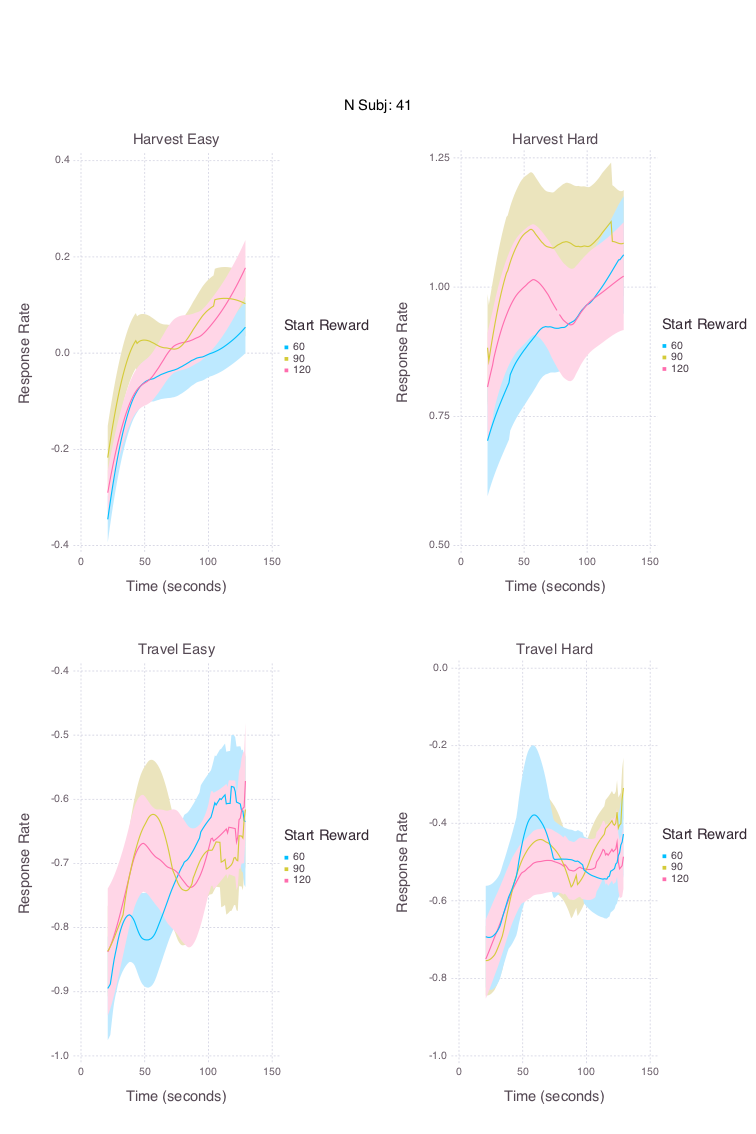

false

In [23]:
plot_group_rr_over_time(pdata)

In [24]:
# change harvest key cond...

# average this over subjects..
function make_smooth_thresh_DF(pdata)
    round_exit_data = by(pdata, [:sub, :trial_num], df -> get_trial_exit_threshs(df));
    round_exit_data.last_reward_sec = round_exit_data.last_reward_time./1000; # in units of 1000...

    smooth_thresh_DF = DataFrame();
    for s_idx in unique(round_exit_data.sub)
        sub_exit_DF = DataFrame();
        #print(s_idx)
        s_data = @where(round_exit_data, :sub .== s_idx);
        s_data.last_reward_time = float.(s_data.last_reward_time);
        s_data.last_reward = float.(s_data.last_reward);
        for t_idx in unique(pdata.trial_num)

            s_trial_data = @where(s_data,:trial_num .== t_idx);

            exit_DF = try
                exit_model_ext = LinearInterpolation(s_trial_data.last_reward_sec, s_trial_data.last_reward, extrapolation_bc=Interpolations.Flat()) # create interpolation function
                #exit_model_ext = extrapolate(interpolate(s_trial_data.last_reward_sec, s_trial_data.last_reward, scheme)
                #exit_model_ext = extrapolate(exit_model, Flat())
                #exit_model = loess(s_trial_data.last_reward_sec, s_trial_data.last_reward,span=.98);
                #us_exit = range(extrema(s_trial_data.last_reward_sec)...; step = 1)
                us_exit = range(extrema(round_exit_data.last_reward_sec)...; step = 1)
                vs_exit = exit_model_ext(us_exit);#Loess.predict(exit_model, us_exit);
                DataFrame(trial_time_sec = us_exit, thresh_smooth = vs_exit, trial_num = t_idx, sub = s_idx,
                                        start_reward = s_trial_data[1,:start_reward],
                                        harvest_key_cond = s_trial_data[1,:harvest_key_cond]);
                catch e
                # print the error for 6...
                bt = backtrace()
                  msg = sprint(showerror, e, bt)
                 # println(msg)
                DataFrame()
            end
            #print(unique(exit_DF.trial_num))

           # if !(nrow(exit_DF) > 0)
            #    print("fail")
            #end
            # throw out subjects for which we missed some
            sub_exit_DF = [sub_exit_DF; exit_DF];
            #print(sub_exit_DF)
        end
        if (nrow(sub_exit_DF) > 1)
            if(length(unique(sub_exit_DF.trial_num)) == length(unique(pdata.trial_num)))
                smooth_thresh_DF = [smooth_thresh_DF; sub_exit_DF];
            else
               println(string(s_idx, ": fail some"))
            end
        else
            println(string(s_idx, ": fail all"))
        end
    end
    return smooth_thresh_DF;
end


make_smooth_thresh_DF (generic function with 1 method)

In [25]:
function plot_group_thresh_over_time(pdata; bounds = [20, 70])

    smooth_thresh_DF = make_smooth_thresh_DF(pdata);
    smooth_thresh_DF.trial_time_sec = ceil.(smooth_thresh_DF.trial_time_sec);

    # get the group mean over time...
    # plot means and sems
    smooth_thresh_means = by(smooth_thresh_DF,
        [:trial_time_sec, :start_reward, :harvest_key_cond],
        :thresh_smooth => mean,
        :thresh_smooth => sem);
    smooth_thresh_means.upper = smooth_thresh_means.thresh_smooth_mean + smooth_thresh_means.thresh_smooth_sem;
    smooth_thresh_means.lower = smooth_thresh_means.thresh_smooth_mean - smooth_thresh_means.thresh_smooth_sem;

    p = plot(@where(smooth_thresh_means, :trial_time_sec .> 1 , :trial_time_sec .< 120), x = :trial_time_sec, y = :thresh_smooth_mean,
        ymin =:lower, ymax =:upper,
        xgroup = :start_reward,
        color = :harvest_key_cond,
        Geom.subplot_grid(
            Geom.line(),
            Geom.ribbon(),
            Coord.Cartesian(ymin = bounds[1], ymax = bounds[2])
            ),
        Guide.ylabel("Exit Threshold"),
        Guide.xlabel("Time (sec)"),
        Scale.xgroup(levels = [60,90,120]),
        Scale.color_discrete_hue(levels = ["EASY", "HARD"]),
        Guide.colorkey(title = "Harvest Cost"),
        Guide.title(string("N Subj: ", length(unique(smooth_thresh_DF.sub)))),
        Theme(panel_fill=colorant"white"));
    draw(PNG(),p)
end


plot_group_thresh_over_time (generic function with 1 method)

3: fail all
15: fail some
16: fail some
25: fail all
29: fail some
32: fail some


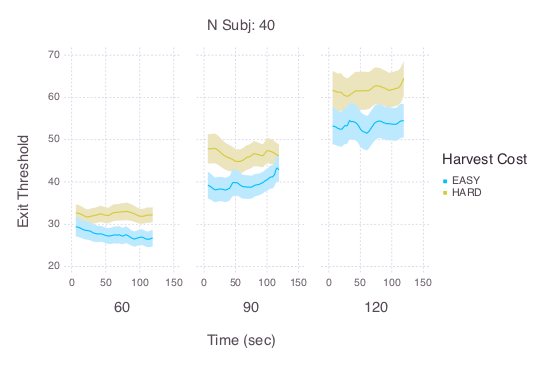

35: fail some
36: fail some
37: fail all


false

In [26]:
plot_group_thresh_over_time(pdata)